# Práctica 2 Hardware Cuántico
**Autor: Jorge Vázquez Pérez**

In [1]:
#%pip install qiskit
#%pip install graphviz

from qiskit import QuantumCircuit, transpile, execute
from qiskit_aer import Aer
from qiskit.visualization import plot_distribution
from qiskit.providers.fake_provider import FakeLimaV2
from qiskit.visualization import plot_gate_map

from qiskit_ibm_provider import IBMProvider
import qiskit.tools.jupyter

IBMProvider.save_account('368ce8e3d58876f8744c71270f2727fd9883b04d75ad646fa5f7345d0b9dede6f06cdc12ebf7e0d0db8a2f0881369da230f432512437401e11ae29dd202b9561', overwrite=True)

%qiskit_version_table

En primer lugar, comenzamos construyendo el circuito deseado.

/home/jvazquez/miniconda3/envs/basic-quantum/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


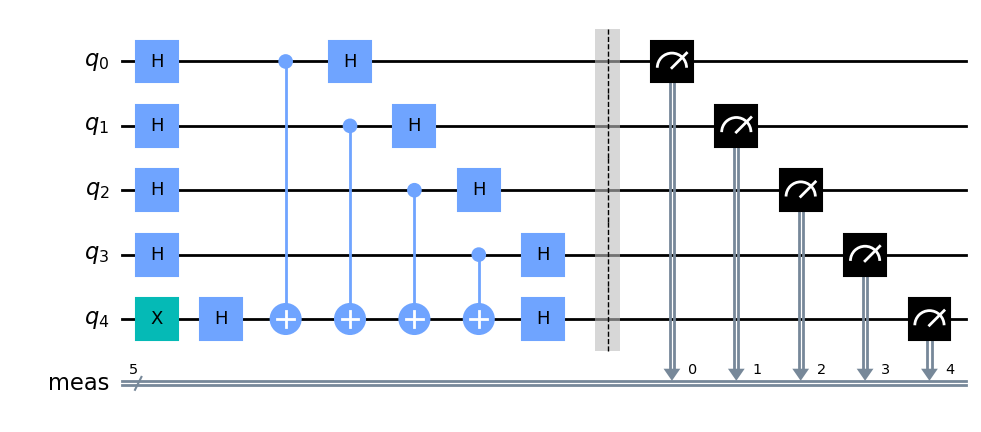

In [2]:
n = 5

# Create the bell state circuit
qc = QuantumCircuit(n)
qc.x(n-1)
qc.h(range(n))
for i in range(0, n-1):
    qc.cx(i, n-1) 
qc.h(range(n))
qc.measure_all()

qc.draw("mpl")

Ahora, seleccionaremos el Fake Backend `FakeLimaV2`. Vemos las puertas que soporta y su *coupling map*, así como una representación del mismo.

['id', 'rz', 'sx', 'x', 'cx', 'reset', 'measure', 'delay']
[[4, 3], [3, 4], [0, 1], [1, 0], [3, 1], [1, 3], [2, 1], [1, 2]]


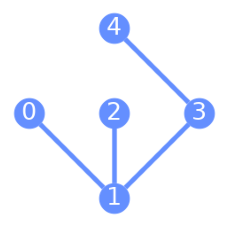

In [3]:
backend = FakeLimaV2()

print(backend.operation_names)
print(backend.coupling_map)
plot_gate_map(backend)

Ahora, es hora de realizar las transpilaciones con los diferentes niveles de optimización: el nivel 0, el nivel 1 y el nivel 2.

/home/jvazquez/miniconda3/envs/basic-quantum/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


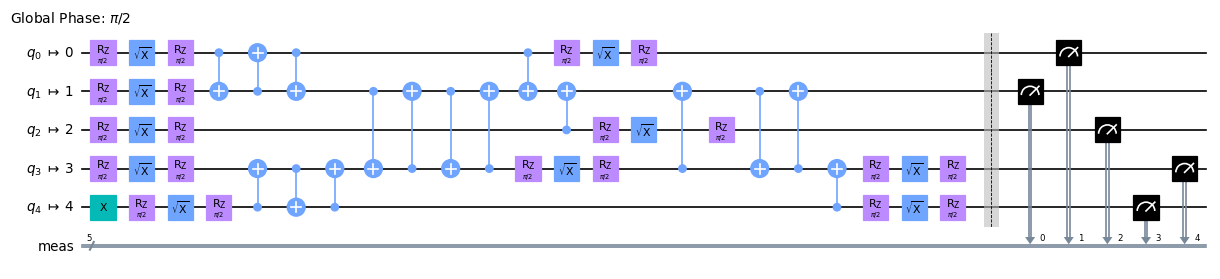

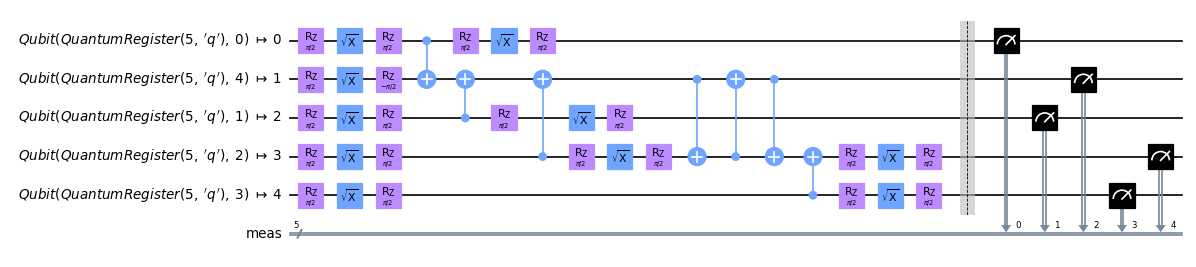

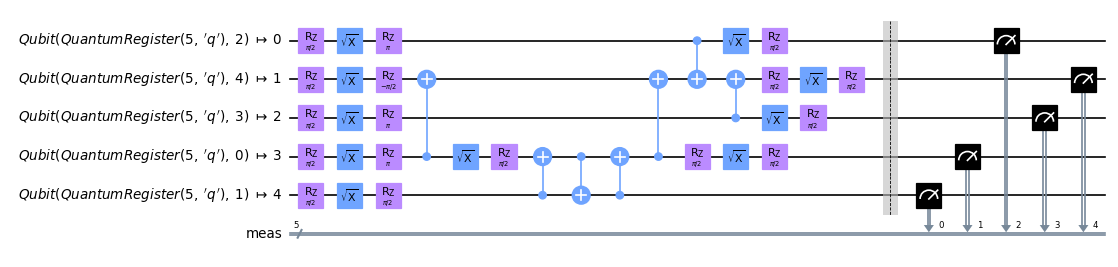

In [4]:
from time import time

times = {}

# Transpile the circuits
start = time()
tqc0 = transpile(qc, backend, optimization_level=0)
end = time()
times["tqc0"] = end - start

start = time()
tqc1 = transpile(qc, backend, optimization_level=1)
end = time()
times["tqc1"] = end - start

start = time()
tqc2 = transpile(qc, backend, optimization_level=2)
end = time()
times["tqc2"] = end - start

tqcs = [(tqc0, "tqc0"), (tqc1, "tqc1"), (tqc2, "tqc2")]

for i, (tqc, _) in enumerate(tqcs):
    display(tqc.draw("mpl", fold=30, scale=0.6))


Ahora, antes de comentar los resultados observables a nivel visual del circuito, vamos a complementar con algunos datos extraíbles de los `QuantumCircuit`.

In [5]:
print("OPTIMIZATION LEVELS INFO")
for i, (tqc, tqc_str) in enumerate(tqcs):
    print(f"\n------ Optimization level {i} info ------")
    print(f"Depth: {tqc.depth()}")
    print(f"Transpilation time: {times[tqc_str]}")
    print(f"Gate counts: {tqc.size()}")

OPTIMIZATION LEVELS INFO

------ Optimization level 0 info ------
Depth: 22
Transpilation time: 0.20424580574035645
Gate counts: 52

------ Optimization level 1 info ------
Depth: 17
Transpilation time: 0.013839244842529297
Gate counts: 42

------ Optimization level 2 info ------
Depth: 16
Transpilation time: 0.02113056182861328
Gate counts: 39


Ahora que tenemos todo esto, podemos comentar las diferencias entre las distintas transpilaciones.

1. **Profundidad de los circuitos.** Vemos en este aspecto una clara reducción de la profundidad, especialmente del nivel 1 con respecto al 0, con una reducción del $27.27\%$. Del nivel 1 al 2 sólamente hay una mejora de una unidad en profundidad, lo que supone un $6.25\%$. Hay que destacar que, de todas formas, estos porcentajes son incluso más grandes si tenemos en cuenta que la función `depth()` de Qiskit tiene en cuenta como operaciones las de medida, las cuales en ningún caso pueden ser optimizadas. Esto tampoco influye enormemente, ya que aunque parece en la representación gráfica que cada medida se corresponde con una capa del circuit, es sólo por la necesidad gráfica de representarlas así, en realidad todas las medidas computan como una sola capa. Por lo que los porcentajes, teniendo esto en cuenta, pasarían a ser $28.57\%$ y $6.67\%$, respectivamente.

2. **Tiempos de transpilación.** Sorprendentemente, un mayor tiempo de transpilación es requerido para la optimización de nivel 0 tanto en comparación con la optimización de nivel 1 como con la de nivel 2. Concretamente, es necesario 10 veces más tiempo para transpilar con el nivel 0 de optimización, que con el nivel 1 o el 2.

3. **Transformaciones**. En cuanto a las transformaciones llevadas a cabo, vemos que el nivel 0 lo único que hace es transformar las puertas aplicadas a las soportadas por el `FakeLimaV2` y aplicar puertas SWAP para poder realizar las CX entre qubits que estes conectados por el *coupling map*. Sin embargo, tanto el nivel 1 como el 2 aplican una disposición inicial (*initial layout*) diferente a la que posee el circuit por defecto para no tener que realizar tantos SWAP después (de hecho en el nivel 0 se pueden observar 4 SWAP, mientras que en el 1 y en el 2 sólo 1 SWAP). Además, tanto el nivel 1 como el 2 hacen una compresión de puertas, por ejemplo, eliminando la puerta X del último qúbit e incorporándola en las fases de la puerta RZ en las que se descomponen las puertas H. La gran diferencia entre la optimización de nivel 1 y la de nivel 2 es que la de nivel 2 lleva a cabo una compresión de puertas más que la de nivel 1 con algunas de las puertas RZ que componen la segunda capa de puertas H del circuíto, lo cual, probablemente, sea el causante de que los SWAP y CX de estas dos transpilaciones sean diferentes.

Y, ahora, veremos cuál es el la relación de salidas correctas entre las distintas transpilaciones y la salida ideal.

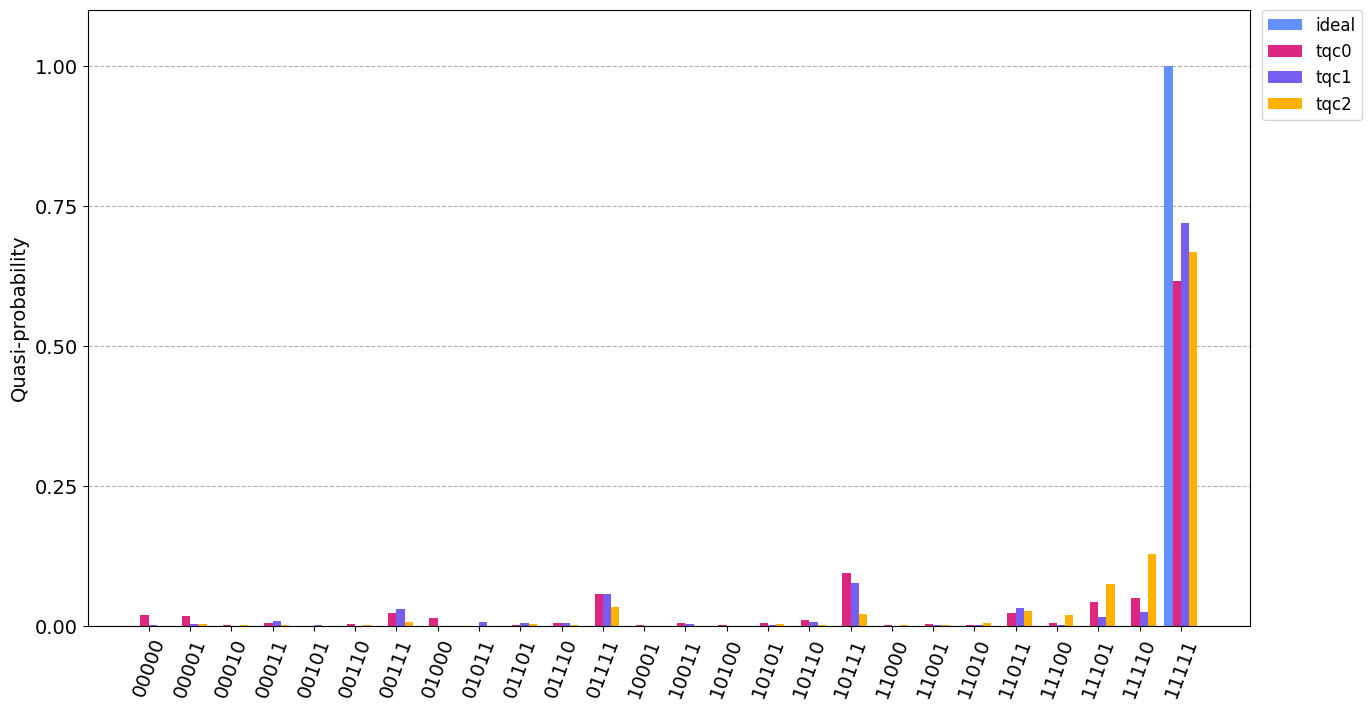

OPTIMIZATION LEVELS CORRECT OUTPUTS
Correct output of ideal: 1.0
Correct output of tqc0: 0.615
Correct output of tqc1: 0.719
Correct output of tqc2: 0.667


In [6]:
shots = 1000
counts = {}

counts["ideal"] = execute(qc, Aer.get_backend("qasm_simulator"), shots=shots).result().get_counts()

for i, (tqc, tqc_str) in enumerate(tqcs):
    counts[tqc_str] = execute(tqc, backend, shots=shots).result().get_counts()

display(plot_distribution([count for _, count in counts.items()], legend=[tqc_str for tqc_str, _ in counts.items()], bar_labels=False, figsize=(15, 8)))

print("OPTIMIZATION LEVELS CORRECT OUTPUTS")
for tqc_str, count in counts.items():
    print(f"Correct output of {tqc_str}: {count['11111']/shots}")

Así pues, vemos que, si bien las tres traspilaciones tienen entre el $55\%$ y el $70\%$ de salidas correctas, el porcentaje de salidas correctas de la traspilación con nivel de optimización 0 es un $10\%$ más bajo que el de los niveles 1 y 2. Esto, probablemente, se deba a que los niveles 1 y 2 tienen una profundidad menor en, como ya vimos, alrededor de un $30\%$. Esto provoca que estas dos transpilaciones sean menos sensibles a la decoherencia, pues el circuíto es más corto y se puede obtener el resultado antes evitando que se pierda más información que en la de nivel 0.

Veamos ahora, transpilando con nivel el nivel por defecto 100 veces y cogiendo la mejor y peor transpilación en clave de profundidad, cuáles son los porcentajes de acierto.  

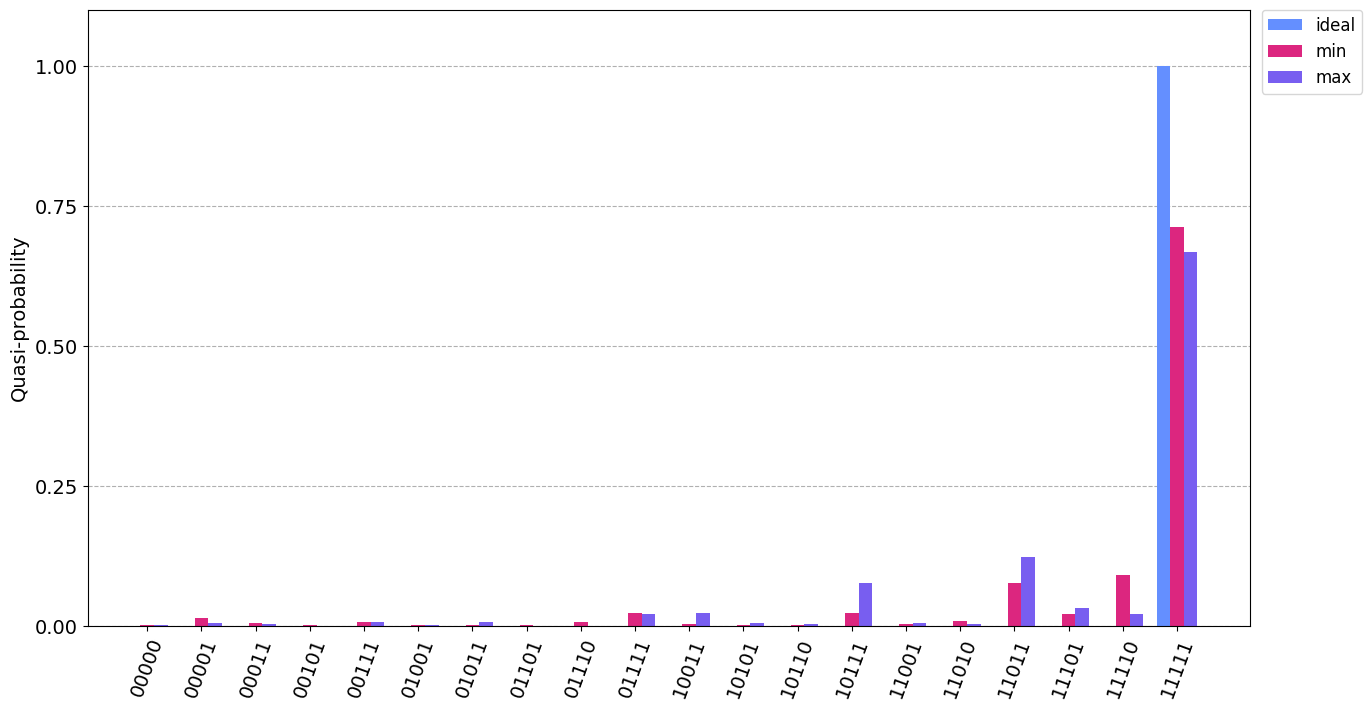

DEPTH OF MIN AND MAX TRANSPILATIONS
Depth of min transpilation: 14
Depth of max transpilation: 17

CORRECT OUTPUTS OF MIN AND MAX TRANSPILATIONS
Correct output of min transpilation: 0.712
Correct output of max transpilation: 0.668


In [7]:
tranpilations = []

for _ in range(100):
    tqc = transpile(qc, backend)
    tranpilations.append(tqc)

    min_transpilation = min(tranpilations, key=lambda tqc: tqc.depth())
    max_transpilation = max(tranpilations, key=lambda tqc: tqc.depth())

counts = {"ideal": counts["ideal"]}
counts["min"] = execute(min_transpilation, backend, shots=shots).result().get_counts()
counts["max"] = execute(max_transpilation, backend, shots=shots).result().get_counts()

display(plot_distribution([count for _, count in counts.items()], legend=[tqc_str for tqc_str, _ in counts.items()], bar_labels=False, figsize=(15, 8)))

print("DEPTH OF MIN AND MAX TRANSPILATIONS")
print(f"Depth of min transpilation: {min_transpilation.depth()}")
print(f"Depth of max transpilation: {max_transpilation.depth()}")

print("\nCORRECT OUTPUTS OF MIN AND MAX TRANSPILATIONS")
print(f"Correct output of min transpilation: {counts['min']['11111']/shots}")
print(f"Correct output of max transpilation: {counts['max']['11111']/shots}")

Por lo tanto, vemos que, con la optimización por defecto, la transpilación es tan buena en términos de porcentajes de acierto como los niveles 1 y 2. Entre las dos transipilaciones, la de menor y mayor profundidad, no vemos mucha diferencia de rendimiento porque la diferencia de profundidad es de menos de un $20\%$ (no suficiente como para tener un gran impacto), similar a lo que pasaba antes con las optimizaciones de nivel 1 y 2.